<a href="https://colab.research.google.com/github/wondercha/DL_experiments/blob/main/CIFAR10_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 256
input_size = 16
hidden_size = 256
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 20
learning_rate = 0.001

print(device)

cuda


In [ ]:
# 전처리
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
patch_size = 16 # 16 pixels

In [ ]:
!pip install einops

In [ ]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 2, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 28,
                depth: int = 2,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
model = ViT().to(device)

In [ ]:
!pip install tensorboardX

In [ ]:
def adjust_learning_rate(optimizer, e):
    lr = learning_rate
    if e >= 50:
        lr /= 10
    #if e >= 100:
    #    lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.002) 
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

# Time Check
import timeit
start_time = timeit.default_timer() # 시작 시간 체크

from tensorboardX import SummaryWriter
writer = SummaryWriter()

%load_ext tensorboard
%tensorboard --logdir {'./runs'}

epochs = 100
steps = 0

train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
for e in range(epochs):
    #adjust_learning_rate(optimizer, e)
    running_loss = 0
    running_acc = 0
    running_total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # origin shape : [bs, 3, 32, 32]
        #images = images.reshape(-1, 32*3, 32).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_total += labels.size(0)
        running_acc += (preds == labels.data).sum().item()

        # tb
        #writer.add_scalar('training loss', running_loss/len(train_loader), e+1)
        #writer.add_scalar('training accuracy', running_acc/running_total, e+1)

    # for 문이 끝나면 실행한다.
    else:
        test_loss = 0
        accuracy = 0
        total = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                #images = images.reshape(-1, 32*3, 32).to(device)
                outputs = model(images)
                test_loss += criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                accuracy += (predicted == labels).sum().item()


        train_losses.append(running_loss/len(train_loader))        
        test_losses.append(test_loss/len(test_loader))
        test_accuracy.append(accuracy/total)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Training Accuracy: {:.3f}.. ".format(running_acc/running_total),
              "Test Accuracy: {:.3f}".format(accuracy/total))

        #tb
        writer.add_scalars('Loss', {'Train loss':running_loss/len(train_loader),
                                    'Test loss':test_loss/len(test_loader)}, e+1)
        writer.add_scalars('Accuracy', {'Train acc':running_acc/running_total,
                                        'Test acc':accuracy/total}, e+1)
        #writer.add_scalar('test loss', test_loss/len(test_loader), e+1)
        #writer.add_scalar('test accuracy', accuracy/total, e+1)

print('Finished Training...')

# Waits for everything to finish running 
terminate_time = timeit.default_timer() # 종료 시간 체크  
print("%f sec" % (terminate_time - start_time))

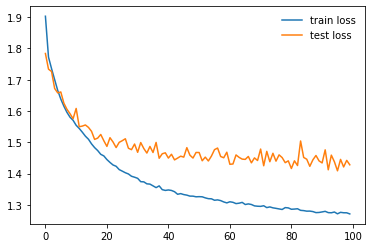

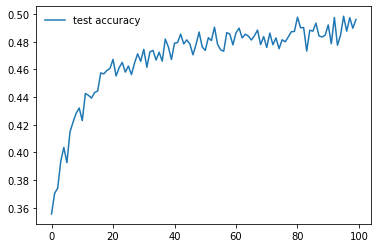

In [ ]:
import matplotlib.pyplot as plt
import datetime

current_dtime = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
rslt_fname = './data/loss_' + current_dtime + '.png'

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend(frameon=False)
#plt.axis([0, epochs, 1, 2])
plt.show()

#plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.legend(frameon=False)
#plt.axis([0, epochs, 0, 1])
plt.show()